# Generador de imágenes - cGAN

Importamos las librerías necesarias para el proyecto.






In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from typing import Optional, Callable
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader
import urllib.request
from zipfile import ZipFile
import torch.optim as optim
from torchvision import transforms, utils as vutils
import matplotlib.pyplot as plt


Luego, definimos las URLs para el conjunto de datos y los archivos CSV, y las rutas donde se guardarán. Después, descargamos y extraemos el conjunto de datos y descargamos los archivos CSV si aún no existen.

In [ ]:
DATASET_ZIP_URL = "https://www.dropbox.com/scl/fi/buygp1u3dlvql1omlgii6/title30cat.zip?rlkey=emlr8c439whnexhezqjanlr19&st=58w2deja&dl=1"
CSV_TEST_URL = "https://www.dropbox.com/scl/fi/5qgqwksr9rz510cqqyzip/book30-listing-test.csv?rlkey=xu6m7bfbp9noefc91difpzix7&st=pmbqqis8&dl=1"
CSV_TRAIN_URL = "https://www.dropbox.com/scl/fi/b28fi1cd6k4vtaj0en1lu/book30-listing-train.csv?rlkey=dd4lrdkoleiedezjzx9ing1yb&st=jwcx2hys&dl=1"

# en caso de no tener los archivos CSV descomente las líneas superiores

DATASET_PATH = "./224x224"
CSV_TEST_PATH = "./book30-listing-test.csv"
CSV_TRAIN_PATH = "./book30-listing-train.csv"
ZIP_PATH = "./title30cat.zip"

if not os.path.exists(DATASET_PATH):
    urllib.request.urlretrieve(DATASET_ZIP_URL, ZIP_PATH)
    with ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(".")
    os.remove(ZIP_PATH)
    print("Dataset descargado y descomprimido exitosamente.")
else:
    print("El dataset ya está descargado.")

if not os.path.exists(CSV_TEST_PATH):
    urllib.request.urlretrieve(CSV_TEST_URL, CSV_TEST_PATH)
    print("CSV de prueba descargado exitosamente.")
else:
    print("El CSV de prueba ya está descargado.")

if not os.path.exists(CSV_TRAIN_PATH):
    urllib.request.urlretrieve(CSV_TRAIN_URL, CSV_TRAIN_PATH)
    print("CSV de entrenamiento descargado exitosamente.")
else:
    print("El CSV de entrenamiento ya está descargado.")

Dataset descargado y descomprimido exitosamente.
CSV de prueba descargado exitosamente.
CSV de entrenamiento descargado exitosamente.


Luego, definimos las URLs para el conjunto de datos y los archivos CSV, y las rutas donde se guardarán. Después, descargamos y extraemos el conjunto de datos y descargamos los archivos CSV si aún no existen.

In [ ]:
class LibrosDataset(Dataset):
    def __init__(self, csv_path: str, images_dir: str):
        """
        Dataset para imágenes de portadas con etiquetas desde un CSV.

        Args:
            csv_path (str): Ruta al archivo CSV con columnas 'filename' y 'genre'.
            images_dir (str): Carpeta donde están las imágenes.
        """
        self.data = pd.read_csv(csv_path, delimiter=";")
        self.images_dir = images_dir
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)), # 224??
            transforms.ToTensor(),
            # transforms.Normalize([0.5]*3, [0.5]*3)
            ])

        # Crear un mapeo de género a índice y viceversa
        self.genres = sorted(self.data['Category'].unique())
        self.genre_to_idx = {genre: idx for idx, genre in enumerate(self.genres)}
        self.idx_to_genre = {idx: genre for genre, idx in self.genre_to_idx.items()}

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.images_dir, row['Filename'])
        label_idx = self.genre_to_idx[row['Category']]
        label_tensor = torch.tensor(label_idx, dtype=torch.long)

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, label_tensor

Establecemos algunos hiperparámetros así como el uso de la GPU

In [ ]:
batch_size = 64
img_size = 64
z_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Esta función de utilidad convierte un tensor de etiquetas en un tensor codificado "one-hot". Esto se utiliza para proporcionar la información de género al modelo GAN condicional.

In [ ]:
# Utilidad: one-hot
def one_hot(labels, num_classes):
    return torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

Este código define la red del Generador para la GAN condicional. Toma como entrada un vector de ruido latente y una etiqueta de género codificada "one-hot" y genera una imagen sintética. La red utiliza capas convolucionales transpuestas para aumentar el tamaño de la entrada al tamaño de imagen deseado.

In [ ]:
# Generator condicional
class Generator(nn.Module):
    def __init__(self, z_dim, genre_dim, img_channels=3, feature_g=64):
        super().__init__()
        input_dim = z_dim + genre_dim
        self.net = nn.Sequential(
            nn.ConvTranspose2d(input_dim, feature_g * 8, 4, 1, 0),
            nn.BatchNorm2d(feature_g * 8), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 8, feature_g * 4, 4, 2, 1),
            nn.BatchNorm2d(feature_g * 4), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_g * 2), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 2, feature_g, 4, 2, 1),
            nn.BatchNorm2d(feature_g), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g, img_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        x = torch.cat([z, labels], dim=1)
        x = x.unsqueeze(2).unsqueeze(3)
        return self.net(x)

Este código define la red del Discriminador para la GAN condicional. Toma como entrada una imagen y una etiqueta de género codificada "one-hot" y produce un único valor que indica si la imagen es real o falsa. La red utiliza capas convolucionales para reducir el tamaño de la entrada. La etiqueta de género se incrusta y concatena con la imagen antes de pasar por las capas convolucionales.

In [ ]:
# Discriminator condicional
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, genre_dim=10, feature_d=64):
        super().__init__()
        self.label_embed = nn.Linear(genre_dim, img_size * img_size)
        self.net = nn.Sequential(
            nn.Conv2d(img_channels + 1, feature_d, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_d * 2), nn.LeakyReLU(0.2),
            nn.Conv2d(feature_d * 2, feature_d * 4, 4, 2, 1),
            nn.BatchNorm2d(feature_d * 4), nn.LeakyReLU(0.2),
            nn.Conv2d(feature_d * 4, 1, 4, 1, 0)
        )

    def forward(self, img, labels):
        label_map = self.label_embed(labels).view(-1, 1, img_size, img_size)
        x = torch.cat([img, label_map], dim=1)
        return self.net(x).view(-1)

Creamos las instancias del dataset y dataloader; así como del generador y del discriminador, y la función de pérdida

In [ ]:
# Entrenamiento
train_dataset = LibrosDataset(CSV_TRAIN_PATH, DATASET_PATH)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
num_classes = len(train_dataset.genre_to_idx)


In [ ]:
print(f"z_dim: {z_dim}, num_classes: {num_classes}")

G = Generator(z_dim, num_classes).to(device)
D = Discriminator(3, num_classes).to(device)
opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
loss_fn = nn.BCEWithLogitsLoss()

z_dim: 100, num_classes: 30


Para guardar en google drive

In [ ]:
# Para poder autoguardar en el drive

from google.colab import drive

drive.mount('/content/drive')

DRIVE_CHECKPOINT_DIR = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
# alternativamente

os.mkdir('/content/drive')

DRIVE_CHECKPOINT_DIR = '/content/drive'

FileExistsError: [Errno 17] File exists: '/content/drive'

Para cargar en memoria un checkpoint con los pesos guardados.

In [ ]:
# para cargar
num_epochs=300

if os.path.exists("drive/MyDrive/cgan_checkpoint.pth"): # cambiar el valor según el archivo
    checkpoint = torch.load("drive/MyDrive/cgan_checkpoint.pth", map_location=device)
    G.load_state_dict(checkpoint['generator_state_dict'])
    D.load_state_dict(checkpoint['discriminator_state_dict'])
    opt_G.load_state_dict(checkpoint['opt_G_state_dict'])
    opt_D.load_state_dict(checkpoint['opt_D_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    loss_G_history = checkpoint['loss_G_history']
    loss_D_history = checkpoint['loss_D_history']
    print(f"✅ Checkpoint cargado. Reanudando desde época {start_epoch} hasta {num_epochs}")

✅ Checkpoint cargado. Reanudando desde época 250 hasta 300


In [ ]:
# para entrenar desde 0

num_epochs= 50
start_epoch = 0
loss_G_history = []
loss_D_history = []

Esta función genera una cuadrícula de imágenes para un género específico utilizando el generador entrenado. Toma como entrada el generador, la dimensión latente, el ID del género, el número de clases, el dispositivo, el mapeo de índice de género y el número de imágenes. Genera vectores latentes y utiliza el ID de género especificado para crear etiquetas codificadas "one-hot". Luego genera imágenes falsas para ese género específico y las muestra en una cuadrícula con el nombre del género como título.

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def generar_imagenes(generator, z_dim, num_classes, idx_to_genre, device, num_imgs=16):
    generator.eval()
    with torch.no_grad():
        # Selecciona géneros aleatorios
        random_labels = torch.randint(0, num_classes, (num_imgs,))
        one_hot_labels = torch.nn.functional.one_hot(random_labels, num_classes).float().to(device)
        z = torch.randn(num_imgs, z_dim).to(device)
        fake_imgs = generator(z, one_hot_labels).detach().cpu()

        # Mostrar con grid
        grid = vutils.make_grid(fake_imgs, nrow=4, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.title("Imágenes generadas por la cGAN")
        plt.show()

        # Mostrar las clases debajo
        for i in range(num_imgs):
            print(f"[{i}] → {idx_to_genre[random_labels[i].item()]}")


Esta función genera una cuadrícula de imágenes para un género específico utilizando el generador entrenado. Toma como entrada el generador, la dimensión latente, el ID del género, el número de clases, el dispositivo, el mapeo de índice de género y el número de imágenes. Genera vectores latentes y utiliza el ID de género especificado para crear etiquetas codificadas "one-hot". Luego genera imágenes falsas para ese género específico y las muestra en una cuadrícula con el nombre del género como título.

In [ ]:

def generar_por_genero(generator, z_dim, genre_id, num_classes, device, idx_to_genre, num_imgs=8):
    generator.eval()
    with torch.no_grad():
        labels = torch.full((num_imgs,), genre_id, dtype=torch.long)
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes).float().to(device)
        z = torch.randn(num_imgs, z_dim).to(device)
        fake_imgs = generator(z, one_hot_labels).detach().cpu()

        grid = vutils.make_grid(fake_imgs, nrow=4, normalize=True)
        plt.figure(figsize=(8, 4))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.title(f"Género: {idx_to_genre[genre_id]}")
        plt.show()


Entrenamiento

In [ ]:
initial_epochs = list(range(start_epoch - len(loss_G_history), start_epoch)) if loss_G_history else []


for epoch in range(start_epoch, num_epochs):
    G.train(), D.train()
    # Accumulators for epoch losses
    epoch_loss_G = 0
    epoch_loss_D = 0
    num_batches = 0

    for real_imgs, labels in tqdm(train_loader):
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        one_hot_labels = one_hot(labels, num_classes).to(device)
        batch_size = real_imgs.size(0)

        # Discriminator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z, one_hot_labels).detach()
        D_real = D(real_imgs, one_hot_labels)
        D_fake = D(fake_imgs, one_hot_labels)

        loss_D = loss_fn(D_real, torch.ones_like(D_real)) + \
                 loss_fn(D_fake, torch.zeros_like(D_fake))

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Generator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z, one_hot_labels)
        D_fake = D(fake_imgs, one_hot_labels)
        loss_G = loss_fn(D_fake, torch.ones_like(D_fake))

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        epoch_loss_G += loss_G.item()
        epoch_loss_D += loss_D.item()
        num_batches += 1


    avg_loss_G = epoch_loss_G / num_batches
    avg_loss_D = epoch_loss_D / num_batches
    loss_G_history.append(avg_loss_G)
    loss_D_history.append(avg_loss_D)


    print(f"Epoch {epoch+1}/{num_epochs} | Loss D: {avg_loss_D:.4f} | Loss G: {avg_loss_G:.4f}")

    # Guardar checkpoint cada 5 épocas
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(DRIVE_CHECKPOINT_DIR, f'cgan_checkpoint.pth')
        torch.save({
          'epoch': epoch,
          'generator_state_dict': G.state_dict(),
          'discriminator_state_dict': D.state_dict(),
          'opt_G_state_dict': opt_G.state_dict(),
          'opt_D_state_dict': opt_D.state_dict(),
          'loss_G_history': loss_G_history,
          'loss_D_history': loss_D_history
        }, checkpoint_path)
        print(f"Checkpoint guardado en época {epoch+1}")

        # Save loss history to a text file
        loss_history_path = os.path.join(DRIVE_CHECKPOINT_DIR, 'cgan_loss_history.txt')
        with open(loss_history_path, 'w') as f:
            for i in range(len(loss_G_history)):
                f.write(f"Epoch {start_epoch + i + 1}: Loss D = {loss_D_history[i]:.4f}, Loss G = {loss_G_history[i]:.4f}\n")
        print(f"Historial de pérdidas guardado en {loss_history_path}")

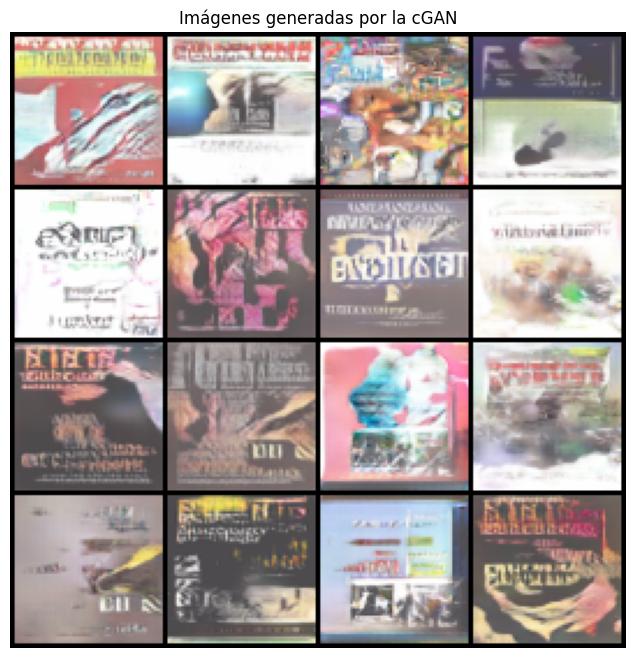

[0] → Comics & Graphic Novels
[1] → Health, Fitness & Dieting
[2] → Reference
[3] → Science & Math
[4] → History
[5] → Comics & Graphic Novels
[6] → Christian Books & Bibles
[7] → Crafts, Hobbies & Home
[8] → Biographies & Memoirs
[9] → Romance
[10] → Comics & Graphic Novels
[11] → Science Fiction & Fantasy
[12] → Mystery, Thriller & Suspense
[13] → Sports & Outdoors
[14] → Science & Math
[15] → Health, Fitness & Dieting


In [ ]:
generar_imagenes(
    generator=G,
    z_dim=100,
    num_classes=len(train_dataset.genre_to_idx),
    idx_to_genre=train_dataset.idx_to_genre,
    device=device,
    num_imgs=16
)


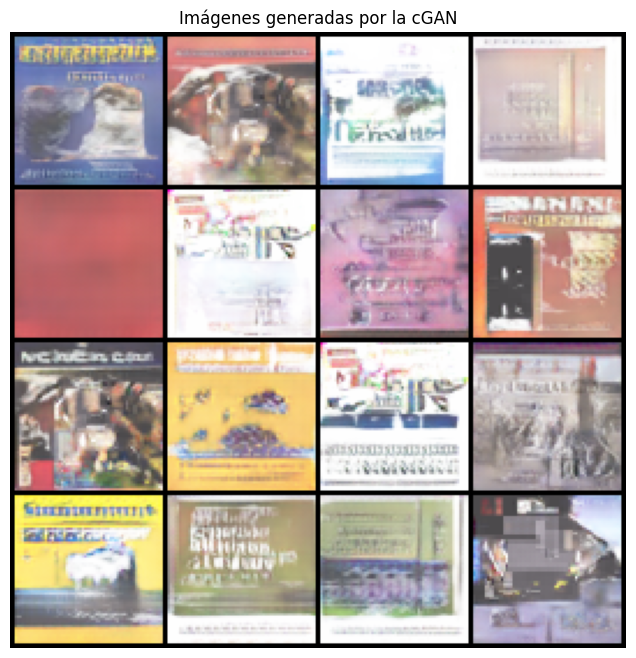

[0] → Science & Math
[1] → History
[2] → Engineering & Transportation
[3] → Christian Books & Bibles
[4] → Law
[5] → Science & Math
[6] → Health, Fitness & Dieting
[7] → Children's Books
[8] → Reference
[9] → Arts & Photography
[10] → Self-Help
[11] → Christian Books & Bibles
[12] → Test Preparation
[13] → Literature & Fiction
[14] → Computers & Technology
[15] → Calendars


In [ ]:
# Generado con 100 epochs (perdí la del primero ciclo de cuando tenía 50)

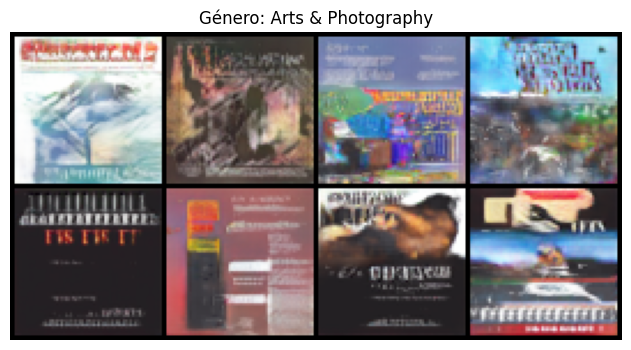

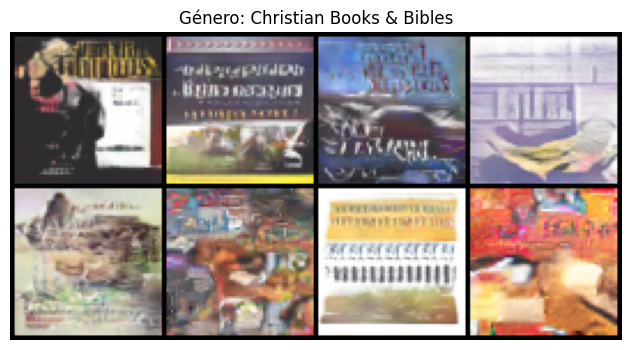

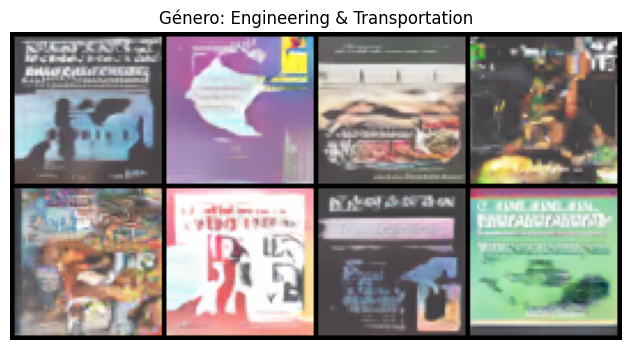

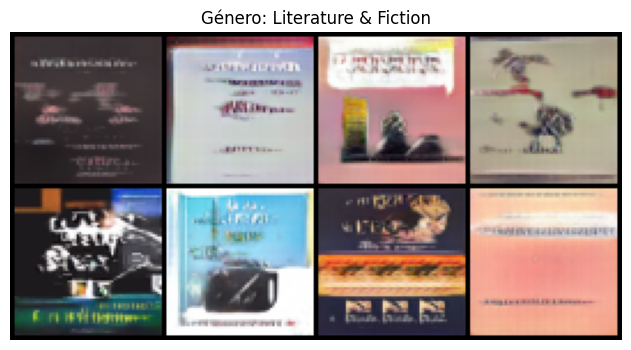

In [ ]:
for genre_id in [0, 5, 10, 15]:
    generar_por_genero(G, z_dim=100, genre_id=genre_id, num_classes=30, device=device, idx_to_genre=train_dataset.idx_to_genre)


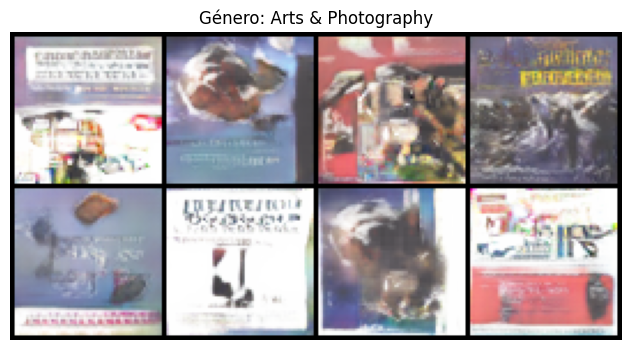

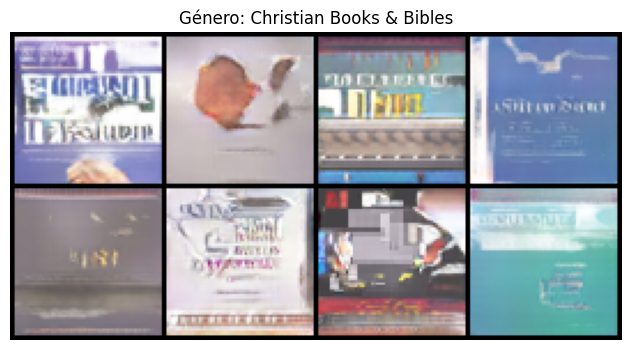

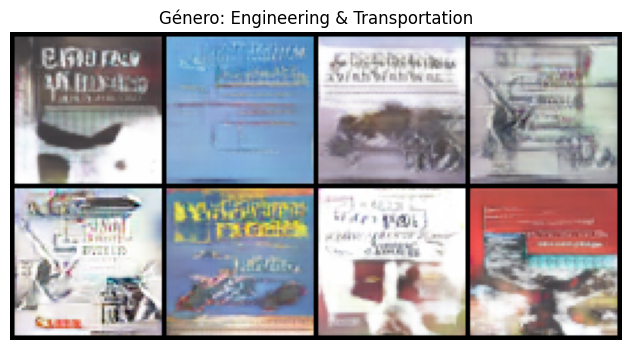

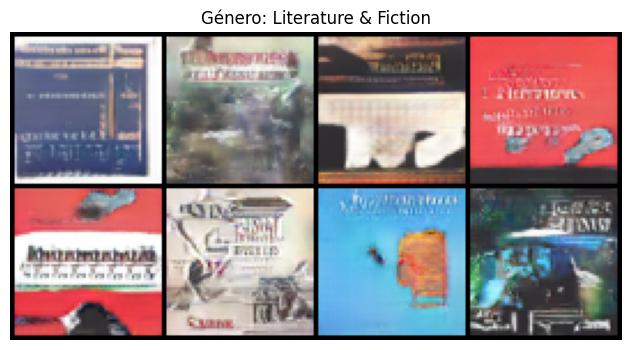

In [ ]:
# muestra por género hecha con 70 epochs